In [2]:
import os
import pandas as pd
import janitor
import warnings
import json
from IPython.display import display

warnings.filterwarnings("ignore")

import numpy as np

FP_VISITS_DATA = "../data/6.3m-ind-domain-data.csv.gz"
FP_VT_LABELS = "../data/yg_virustotal_dat.csv"
FILEPATHS = [value for name, value in globals().items() if name.startswith("FP_")]
for file_path in FILEPATHS:
    try:
        assert os.path.exists(file_path), f"File not found: {file_path}"
    except AssertionError:
        print(f"File not found: {file_path}.")

In [11]:
df_vt_visits = (
    pd.read_csv(FP_VT_LABELS)
    # ===============================================
    # Defining labels
    .assign(
        malicious_bool=lambda df_: np.where(df_["malicious"] >= 2, True, False),
        suspicious_bool=lambda df_: df_["suspicious"].astype("bool"),
    ).rename_column("filename", "domain")
    # ===============================================
    # Get visit weights
    .merge(
        (
            pd.read_csv(FP_VISITS_DATA)
            .rename_column("private_domain", "domain")
            .groupby("domain", as_index=False)
            .agg(visits=("domain", "size"), visit_duration=("visit_duration", "sum"))
        ),
        how="left",
        on="domain",
        validate="1:1",
    )
    # ===============================================
    # retrieve YG category for completeness
    .merge(
        (
            pd.read_csv(FP_VISITS_DATA)
            .rename_column("private_domain", "domain")
            .groupby(["domain", "category"])
            .size()
            .reset_index(name="visits")
            .sort_values("visits", ascending=False, ignore_index=True)
            .remove_columns("visits")
            .rename_column("category", "yougov")
            .drop_duplicates("domain", keep="first")
        ),
        how="left",
        on="domain",
        validate="1:1",
    )
    # ===============================================
    .reorder_columns(
        [
            "domain",
            "malicious",
            "malicious_bool",
            "forcepoint",
            "sophos",
            "bitdefender",
            "comodo",
            "alphamnt",
            "yougov",
        ]
    )
)
display(df_vt_visits)
df_vt_visits.info()

,domain,malicious,malicious_bool,forcepoint,sophos,bitdefender,comodo,alphamnt,yougov,harmless,suspicious,undetected,timeout,suspicious_bool,visits,visit_duration
0,teatroporno.com,0,False,sex,sexually explicit,porn,NaN,NaN,Adult,68,0,20,0,False,3,8
1,commissionsoup.com,0,False,financial data and services,NaN,financial,NaN,Business/Economy,Business,68,0,20,0,False,85,248
2,filesanywhere.com,0,False,personal network storage and backup,personal network storage,computersandsoftware,NaN,"File Sharing/Storage, Information Technology",NaN,67,0,20,0,False,10,76
3,lasc.org,0,False,NaN,NaN,NaN,NaN,Government/Legal,NaN,67,0,20,0,False,2,122
4,faron.com,0,False,NaN,NaN,NaN,NaN,"Business/Economy, Health",NaN,67,0,21,0,False,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64015,givex.com,0,False,NaN,NaN,NaN,NaN,Business/Economy,Business,68,0,19,0,False,2,156
64016,diocesemo.org,0,False,widely-known religions,NaN,education,NaN,Religion,NaN,65,0,22,0,False,11,782
64017,karatemart.com,0,False,NaN,NaN,NaN,NaN,"Shopping, Weapons",NaN,67,0,20,0,False,2,12
64018,inthegardenradio.com,1,False,shopping,NaN,onlineshop,media sharing,NaN,NaN,66,0,21,0,False,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64020 entries, 0 to 64019
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   domain           64020 non-null  object
 1   malicious        64020 non-null  int64 
 2   malicious_bool   64020 non-null  bool  
 3   forcepoint       47931 non-null  object
 4   sophos           27111 non-null  object
 5   bitdefender      43373 non-null  object
 6   comodo           13121 non-null  object
 7   alphamnt         36054 non-null  object
 8   yougov           25611 non-null  object
 9   harmless         64020 non-null  int64 
 10  suspicious       64020 non-null  int64 
 11  undetected       64020 non-null  int64 
 12  timeout          64020 non-null  int64 
 13  suspicious_bool  64020 non-null  bool  
 14  visits           64020 non-null  int64 
 15  visit_duration   64020 non-null  int64 
dtypes: bool(2), int64(7), object(7)
memory usage: 7.0+ MB


## Sample

### Malicious - weighted by visits

In [15]:
df_mal_20random = (
    df_vt_visits
    .query("malicious_bool==1")
    .sample(n=20, weights="visits", random_state=0)
    .sort_values("visits", ascending=False)
    .reset_index(drop=True)
)
df_mal_20random

,domain,malicious,malicious_bool,forcepoint,sophos,bitdefender,comodo,alphamnt,yougov,harmless,suspicious,undetected,timeout,suspicious_bool,visits,visit_duration
0,omnatuor.com,6,True,information technology. potentially unwanted s...,content delivery,NaN,NaN,Suspicious,NaN,61,2,18,0,True,1408,22730
1,glersakr.com,2,True,information technology. potentially unwanted s...,content delivery,NaN,NaN,Suspicious,NaN,64,2,19,0,True,705,29366
2,rockslootni.com,11,True,malicious web sites,spyware and malware,NaN,NaN,Malicious,NaN,56,0,20,0,False,500,11178
3,picpushes.com,3,True,web infrastructure,photo galleries,parked,NaN,Phishing,NaN,63,0,21,0,False,470,15240
4,opinionsquare.com,2,True,pay-to-surf,NaN,misc,NaN,Ads/Analytics,Business,65,0,20,0,False,442,7719
5,loader-professional.com,4,True,NaN,content delivery,parked,NaN,NaN,NaN,63,0,20,0,False,360,4982
6,g-sponsored-results.com,3,True,search engines and portals,NaN,NaN,NaN,"Phishing, Search Engines/Portals",Business,66,0,18,0,False,275,8536
7,tei.ai,2,True,information technology,NaN,financial,NaN,Finance,Business,65,0,20,0,False,156,2276
8,jucydate.com,8,True,adult content,sexually explicit,onlinedating,NaN,NaN,"Adult, Information Technology",61,0,19,0,False,147,4456
9,onmarshtompor.com,2,True,advertisements. potentially unwanted software,information technology,parked,NaN,Potentially Unwanted Programs,NaN,64,3,18,0,True,119,390


In [5]:
def retrieve_vt_vendors_results(domain, ix=None, category="malicious"):
    """
    Prints the list of antivirus vendors that flagged the domain as malicious,
    based on the VirusTotal JSON file named {domain}.json.

    Args:
        domain: Domain name (without ".json").
        ix: Optional index for printing (e.g., from enumeration).
    """
    domain_path = "".join(["payloads_json/", domain, ".json"])

    if not os.path.exists(domain_path):
        print(f"Missing: {domain_path}")
        return

    try:
        print("=" * 30)
        with open(domain_path, "r") as f:
            data = json.load(f)
            results = data["data"]["attributes"]["last_analysis_results"]

            malicious_vendors = [
                (vendor, details.get("result"))
                for vendor, details in results.items()
                if details.get("result") == category
            ]

            prefix = f"{ix+1}) " if ix is not None else ""
            print(f"{prefix}{domain}: {len(malicious_vendors)} flag(s)")
            for vendor, result in malicious_vendors:
                print(f" - {vendor}: {result}")
    except (json.JSONDecodeError, KeyError, TypeError) as e:
        print(f"Error processing {domain_path}: {e}")

    return None

In [6]:
for ix, domain in enumerate(df_mal_20random["domain"].tolist()):
    retrieve_vt_vendors_results(domain)

womenworking.com: 2 flag(s)
 - CRDF: malicious
 - Seclookup: malicious
rndskittytor.com: 2 flag(s)
 - Seclookup: malicious
 - Dr.Web: malicious
hyourpackagetrackednow.com: 2 flag(s)
 - Seclookup: malicious
 - Heimdal Security: malicious
dramacool9.co: 3 flag(s)
 - Seclookup: malicious
 - CyRadar: malicious
 - VIPRE: malicious
omnatuor.com: 5 flag(s)
 - ESTsecurity: malicious
 - CyRadar: malicious
 - Webroot: malicious
 - VIPRE: malicious
 - malwares.com URL checker: malicious
watchseriesfree.co: 2 flag(s)
 - CRDF: malicious
 - Seclookup: malicious
glersakr.com: 2 flag(s)
 - CyRadar: malicious
 - Dr.Web: malicious
jucydate.com: 5 flag(s)
 - CRDF: malicious
 - Lionic: malicious
 - CyRadar: malicious
 - VIPRE: malicious
 - malwares.com URL checker: malicious
g-sponsored-results.com: 1 flag(s)
 - Seclookup: malicious
loader-professional.com: 2 flag(s)
 - ADMINUSLabs: malicious
 - CyRadar: malicious
onmarshtompor.com: 2 flag(s)
 - CyRadar: malicious
 - Webroot: malicious
effectivedisplayfor

### Malicious - weighted by duration

In [7]:
df_mal_20random_duration = (
    df_vt_visits.query("malicious_bool==1").sample(
        n=20, weights="visit_duration", random_state=0
    )
    .reset_index(drop=True)
)
df_mal_20random_duration

,domain,malicious,malicious_bool,suspicious_bool,forcepoint,sophos,bitdefender,comodo,alphamnt,yougov,harmless,suspicious,undetected,timeout,visits,visit_duration
0,bflix.to,2,True,True,entertainment,video hosting,videos,NaN,"Entertainment, Video/Multimedia","Entertainment, Illegal Content",63,1,21,0,152,53296
1,reimagemac.com,2,True,False,information technology,information technology,business,media sharing,Information Technology,NaN,65,0,21,0,18,129588
2,watchseriesfree.co,2,True,False,entertainment,NaN,misc,NaN,"Entertainment, Scam/Illegal/Unethical, Video/M...",Entertainment,66,0,20,0,84,23194
3,dramacool9.co,3,True,False,hacking,video hosting,blogs,NaN,"Entertainment, Media Sharing, Scam/Illegal/Une...",Entertainment,64,0,20,0,34,15014
4,huggingface.co,2,True,False,educational materials,information technology,business,NaN,"Business/Economy, Information Technology","Business, Education, Information Technology",65,0,20,0,314,25200
5,beautiful.ai,2,True,False,information technology,general business,business,NaN,NaN,NaN,67,0,18,0,264,19268
6,bigwank.com,2,True,False,sex,NaN,porn,NaN,NaN,Adult,66,0,19,0,56,2606
7,toglooman.com,6,True,False,information technology,general business,parked,NaN,Malicious,NaN,60,0,21,0,383,45370
8,permissionresearch.com,2,True,False,pay-to-surf,NaN,business,NaN,Business/Economy,"Business, Education",65,0,20,0,63,7147
9,glersakr.com,2,True,True,information technology. potentially unwanted s...,content delivery,NaN,NaN,Suspicious,NaN,64,2,19,0,705,29366


In [8]:
for ix, domain in enumerate(df_mal_20random_duration["domain"].tolist()):
    retrieve_vt_vendors_results(domain)

bflix.to: 2 flag(s)
 - CRDF: malicious
 - Seclookup: malicious
reimagemac.com: 2 flag(s)
 - Seclookup: malicious
 - Heimdal Security: malicious
watchseriesfree.co: 2 flag(s)
 - CRDF: malicious
 - Seclookup: malicious
dramacool9.co: 3 flag(s)
 - Seclookup: malicious
 - CyRadar: malicious
 - VIPRE: malicious
huggingface.co: 2 flag(s)
 - CyRadar: malicious
 - malwares.com URL checker: malicious
beautiful.ai: 1 flag(s)
 - CRDF: malicious
bigwank.com: 2 flag(s)
 - Quttera: malicious
 - Heimdal Security: malicious
toglooman.com: 6 flag(s)
 - CRDF: malicious
 - alphaMountain.ai: malicious
 - Seclookup: malicious
 - CyRadar: malicious
 - Dr.Web: malicious
 - Webroot: malicious
permissionresearch.com: 1 flag(s)
 - Dr.Web: malicious
glersakr.com: 2 flag(s)
 - CyRadar: malicious
 - Dr.Web: malicious
123movies.net: 2 flag(s)
 - CRDF: malicious
 - Seclookup: malicious
hdtoday.ru: 2 flag(s)
 - CRDF: malicious
 - Seclookup: malicious
ationwindon.com: 1 flag(s)
 - ESTsecurity: malicious
picpushes.com:

### Suspcious - weighted by visits

In [9]:
df_sus_20random = (
    df_vt_visits.query("malicious_bool==0")
    .query("suspicious_bool==1")
    .sample(n=20, weights="visits", random_state=0)
    .reset_index(drop=True)
)
df_sus_20random

,domain,malicious,malicious_bool,suspicious_bool,forcepoint,sophos,bitdefender,comodo,alphamnt,yougov,harmless,suspicious,undetected,timeout,visits,visit_duration
0,privatelink.de,0,False,True,proxy avoidance,information technology,computersandsoftware,mobile communications,"Information Technology, Suspicious",Business,66,1,20,0,26006,118183
1,zoho.com,0,False,True,hosted business applications,information technology,computersandsoftware,NaN,Productivity Applications,Business,70,1,16,0,15246,329232
2,onlinebookclub.org,0,False,True,educational materials,reference,business,NaN,"Arts/Culture, Entertainment","Education, Entertainment",68,1,18,0,69,790
3,onlyfans.com,0,False,True,adult content,social networks,porn,NaN,"Adult/Mature, Pornography, Social Networking","Adult, Business",69,1,17,0,5805,190272
4,rewardia.com,0,False,True,information technology,NaN,advice,NaN,Suspicious,"Entertainment, Games",65,1,21,0,2823,111854
5,rayjump.com,0,False,True,business and economy,games,misc,NaN,NaN,Business,68,1,18,0,326,4562
6,chkmkt.com,0,False,True,NaN,NaN,NaN,NaN,"Business/Economy, Information Technology",Business,66,1,20,0,206,2330
7,honeygain.com,0,False,True,business and economy,information technology,NaN,NaN,Information Technology,Business,68,1,18,0,2885,53194
8,hentaifox.com,0,False,True,sex,sexually explicit,porn,NaN,Pornography,"Adult, Entertainment",67,1,19,0,1468,17856
9,belhaven.edu,0,False,True,educational institutions,educational institutions,education,NaN,Education,Education,66,1,21,0,22,908


## Manual analyses (any.run)

In [16]:
df_mal_20random

,domain,malicious,malicious_bool,forcepoint,sophos,bitdefender,comodo,alphamnt,yougov,harmless,suspicious,undetected,timeout,suspicious_bool,visits,visit_duration
0,omnatuor.com,6,True,information technology. potentially unwanted s...,content delivery,NaN,NaN,Suspicious,NaN,61,2,18,0,True,1408,22730
1,glersakr.com,2,True,information technology. potentially unwanted s...,content delivery,NaN,NaN,Suspicious,NaN,64,2,19,0,True,705,29366
2,rockslootni.com,11,True,malicious web sites,spyware and malware,NaN,NaN,Malicious,NaN,56,0,20,0,False,500,11178
3,picpushes.com,3,True,web infrastructure,photo galleries,parked,NaN,Phishing,NaN,63,0,21,0,False,470,15240
4,opinionsquare.com,2,True,pay-to-surf,NaN,misc,NaN,Ads/Analytics,Business,65,0,20,0,False,442,7719
5,loader-professional.com,4,True,NaN,content delivery,parked,NaN,NaN,NaN,63,0,20,0,False,360,4982
6,g-sponsored-results.com,3,True,search engines and portals,NaN,NaN,NaN,"Phishing, Search Engines/Portals",Business,66,0,18,0,False,275,8536
7,tei.ai,2,True,information technology,NaN,financial,NaN,Finance,Business,65,0,20,0,False,156,2276
8,jucydate.com,8,True,adult content,sexually explicit,onlinedating,NaN,NaN,"Adult, Information Technology",61,0,19,0,False,147,4456
9,onmarshtompor.com,2,True,advertisements. potentially unwanted software,information technology,parked,NaN,Potentially Unwanted Programs,NaN,64,3,18,0,True,119,390


1. [x] omnatuor.com | https://any.run/report/ae7c9061897fa2d7539573e4da0ed2e8ff677f0d3a495ddf0fbd70a36b9a2b25/ca964b96-1a24-443a-a946-f86fd20f11ca

1. [x] glersakr.com	| https://any.run/report/0cd70405125de25e5c8c9eb4b93ce377b726e77ac63f2e98bf3e34b506243617/cdb3e036-5112-4eb2-b256-fefe4aa06d5d

1. [x] rockslootni.com	| https://app.any.run/tasks/421426b0-3449-45c4-bd01-cb0f5865402e [self | no mal]
    - malware https://socradar.io/microsoft-and-vmware-warn-of-ongoing-chromeloader-malware-campaign

1. [x] picpushes.com	| https://app.any.run/tasks/353fd596-b4b1-4119-a060-d51be75cb977 [self | no mal]
    - https://forums.malwarebytes.com/topic/287556-issue-with-riskware-popup/
    - unresolved DNS

1. [x] opinionsquare.com | https://any.run/report/1910b88e002009ffd33326117f51a6156209caab8244a7c902a9841272b196b9/d2d5677d-3176-418a-84d4-9a88deeb0330 [self | no mal]
    - malware https://www.shouldiremoveit.com/OpinionSquare-40133-program.aspx

1. loader-professional.com	| https://app.any.run/tasks/a490aa93-89c9-4ec7-bf4f-1fbe4e78f10b
    - parked
    
1. g-sponsored-results.com | https://app.any.run/tasks/de84e331-b3a9-4daa-914d-03f914b3f9e5 [self | no mal]
    - squatting
    - https://www.malwarebytes.com/blog/news/2024/05/watch-out-for-tech-support-scams-lurking-in-sponsored-search-results
   
1. [x] tei.ai | https://app.any.run/tasks/d3a9d284-8686-434a-9c73-25c6d5f51f95 [self | no mal]
    - https://malwaretips.com/blogs/remove-tei-ai
    
1. [x] jucydate.com	| https://app.any.run/tasks/5c001941-ead4-403c-8877-480b43215c28 [self | no mal]
    - https://www.enigmasoftware.com/jucydatecom-removal
    - https://gridinsoft.com/online-virus-scanner/url/jucydate-com
    
1. [x] onmarshtompor.com | https://any.run/report/acf70a483a05e6cd80c23de709521b1fff54d11c9671341eefaab27747ff37c8/96af40a3-70be-445f-b57f-e04f3c82a700    
    
1. [x] effectivedisplayformats.com | https://any.run/report/0e832244e9efe2a251be7b80e2ae2eb6de3ac4e1df1d728dbf37ec62ed96a54d/8338f1cb-df56-47c8-8056-27050136efb4    
    
1. [x] watchseriesfree.co | https://app.any.run/tasks/fec38825-5b28-4db1-82ec-6ae7971d87d6 [self | no mal]
    - watchseries.im https://any.run/report/b068ac7e1cd4f3443e3794c51605e724ded0475ddf28960b9182406fae7095b9/b95f5f5d-6cc6-4cb2-9760-1a9c3d2454a0    
    
1. [x] hyourpackagetrackednow.com | https://app.any.run/tasks/52cad89a-b4b3-4b70-a9bb-a8bfc8d97b5a [self | no mal]
    - mal executable https://www.hybrid-analysis.com/sample/bd85622762bf36b5e2416519702b4c1b2346c204aa615aea7ff67b034fec43e7/5cb386af0288384094e3a178
    
1. [x] hetaint.com	| https://any.run/report/81a9e8c5328f8f6c87bfb59c22a5fff0f44105b75fb142c8950c041462b6d7af/e5e7fd77-7d7a-4442-b8f1-ee3a3350bbf4
    - parked
    - https://malwaretips.com/blogs/remove-hetaint-com/
    
1. [x] rndskittytor.com	| https://app.any.run/tasks/64275b64-cf0b-491b-ae8f-ec55c4a6d847
     - parked
     
1. [x] dramacool9.co | https://any.run/report/fc4176fb99dbd542c8bd421870a715e877df675ac89f656c7f8a72c45b91f7c2/db4636b2-9ee0-4657-8c15-37e6450c065b

1. vacumdent.com | https://app.any.run/tasks/99cb2984-7bfa-4106-b61a-b3dc0bc97651 [self | no mal]
    - DNS unresolved    

1. womenworking.com | https://app.any.run/tasks/6e7e0384-8ca8-421a-a51b-cfd0f81d1d99 [self | no mal]

1. [x] movies2watch.tv | https://any.run/report/cb43ae4641d3e65daad9d13bf862f68ae1ca5ba61fa2c851c4e124df56809254/5b1abd54-7b7f-40c3-8c1c-28ca52a792b1

1. [x] cloudflare-ipfs.com	| https://any.run/report/77dca4b86053464259f07dc26c6f846de3fb9a79e783d2b021d683f97480355d/8fbcbb7f-4fdc-44e0-a84f-3a0a759a82a0

Labels switching over time

MD5: F5DCD514869953866A8543D1D67B0336

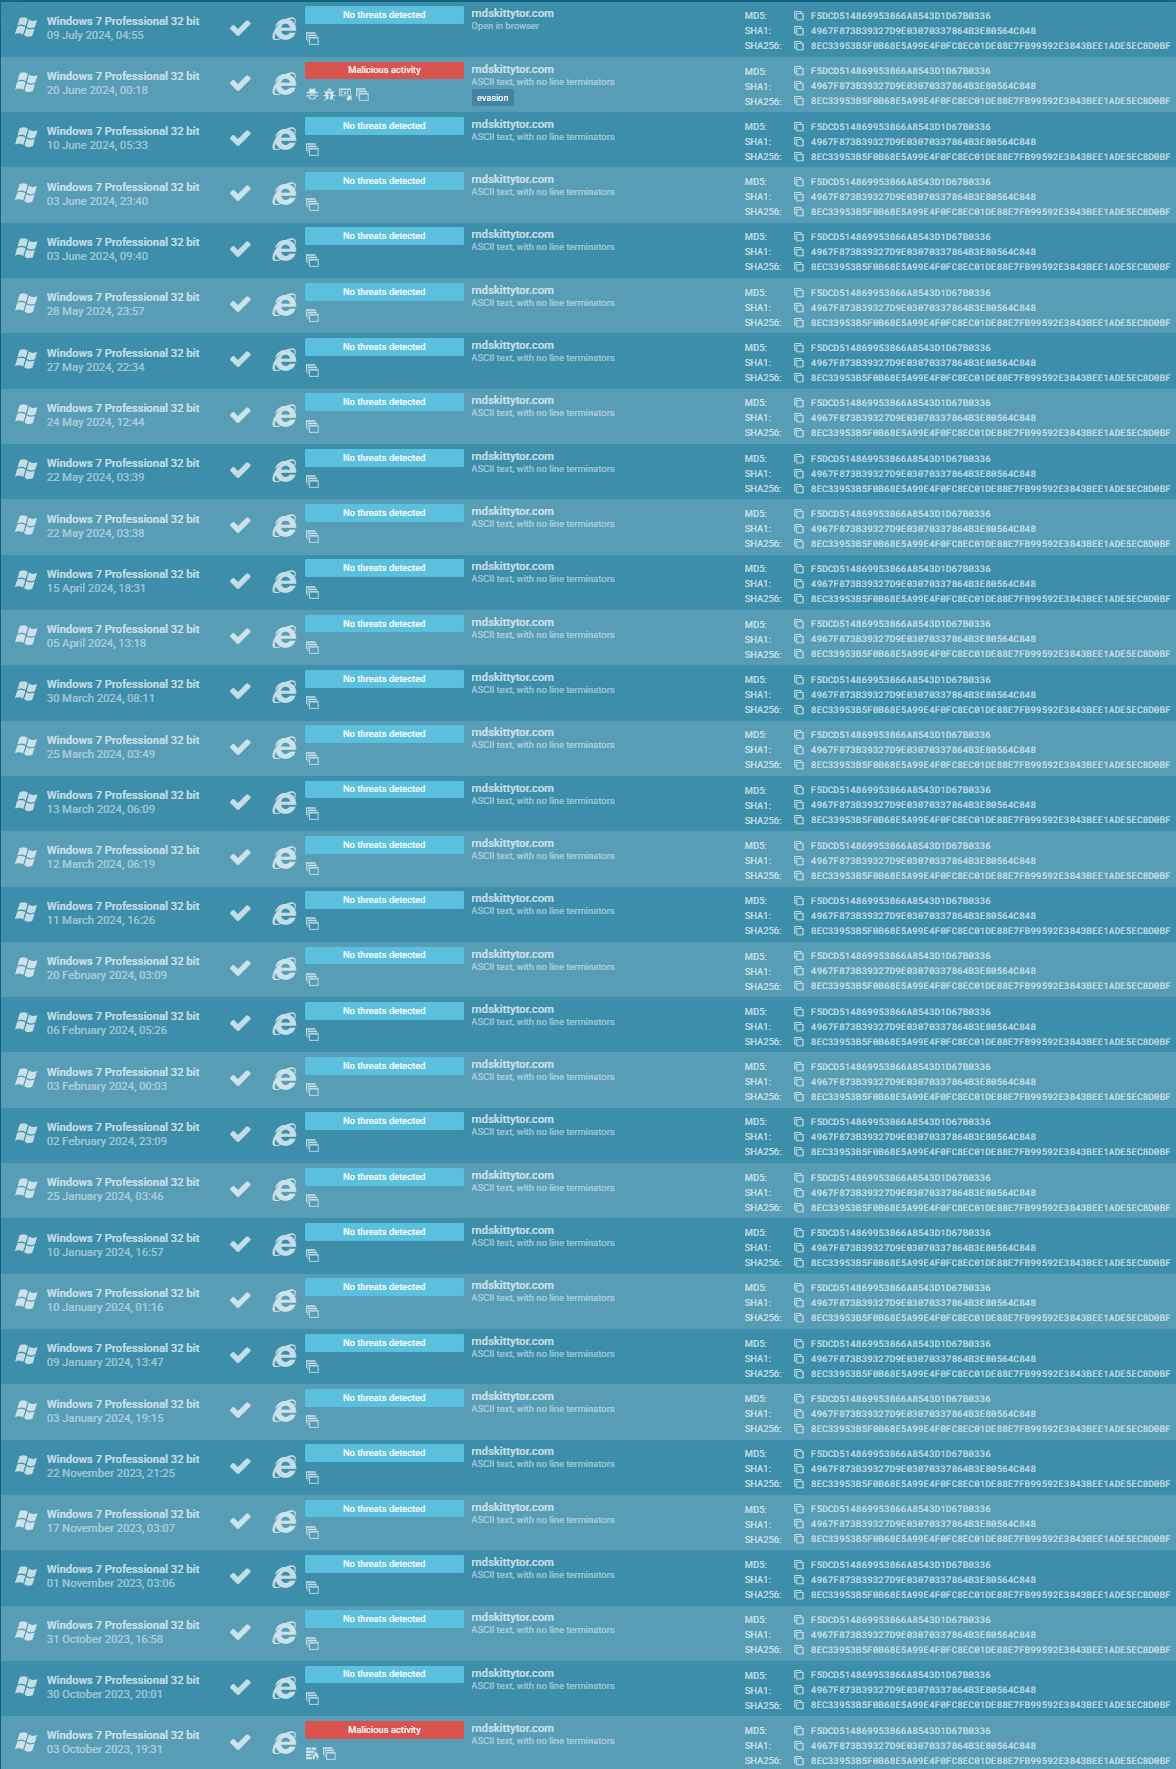

## Sampling one example payload of malicious site

In [11]:
with open("payloads_json/dramacool9.co.json", "r") as f:
    data = json.load(f)
data

{'data': {'attributes': {'last_dns_records': [{'type': 'AAAA',
     'value': '2606:4700:3034::ac43:bea2',
     'ttl': 300},
    {'type': 'A', 'value': '172.67.190.162', 'ttl': 300},
    {'priority': 10, 'type': 'MX', 'value': 'mx.yandex.net', 'ttl': 300},
    {'type': 'NS', 'value': 'elma.ns.cloudflare.com', 'ttl': 21600},
    {'rname': 'dns.cloudflare.com',
     'retry': 2400,
     'refresh': 10000,
     'minimum': 3600,
     'value': 'elma.ns.cloudflare.com',
     'expire': 604800,
     'ttl': 3600,
     'serial': 2300196575,
     'type': 'SOA'},
    {'type': 'AAAA', 'value': '2606:4700:3035::6815:33e8', 'ttl': 300},
    {'type': 'NS', 'value': 'tom.ns.cloudflare.com', 'ttl': 21600},
    {'type': 'A', 'value': '104.21.51.232', 'ttl': 300}],
   'jarm': '27d3ed3ed0003ed1dc42d43d00041d6183ff1bfae51ebd88d70384363d525c',
   'whois': 'Admin City: REDACTED FOR PRIVACY\nAdmin Country: REDACTED FOR PRIVACY\nAdmin Organization: REDACTED FOR PRIVACY\nAdmin Postal Code: REDACTED FOR PRIVACY\nAdm

In [12]:
data

{'data': {'attributes': {'last_dns_records': [{'type': 'AAAA',
     'value': '2606:4700:3034::ac43:bea2',
     'ttl': 300},
    {'type': 'A', 'value': '172.67.190.162', 'ttl': 300},
    {'priority': 10, 'type': 'MX', 'value': 'mx.yandex.net', 'ttl': 300},
    {'type': 'NS', 'value': 'elma.ns.cloudflare.com', 'ttl': 21600},
    {'rname': 'dns.cloudflare.com',
     'retry': 2400,
     'refresh': 10000,
     'minimum': 3600,
     'value': 'elma.ns.cloudflare.com',
     'expire': 604800,
     'ttl': 3600,
     'serial': 2300196575,
     'type': 'SOA'},
    {'type': 'AAAA', 'value': '2606:4700:3035::6815:33e8', 'ttl': 300},
    {'type': 'NS', 'value': 'tom.ns.cloudflare.com', 'ttl': 21600},
    {'type': 'A', 'value': '104.21.51.232', 'ttl': 300}],
   'jarm': '27d3ed3ed0003ed1dc42d43d00041d6183ff1bfae51ebd88d70384363d525c',
   'whois': 'Admin City: REDACTED FOR PRIVACY\nAdmin Country: REDACTED FOR PRIVACY\nAdmin Organization: REDACTED FOR PRIVACY\nAdmin Postal Code: REDACTED FOR PRIVACY\nAdm

In [13]:
data.keys()

dict_keys(['data'])

In [14]:
data["data"].keys()

dict_keys(['attributes', 'type', 'id', 'links'])

In [15]:
data["data"]["attributes"]

{'last_dns_records': [{'type': 'AAAA',
   'value': '2606:4700:3034::ac43:bea2',
   'ttl': 300},
  {'type': 'A', 'value': '172.67.190.162', 'ttl': 300},
  {'priority': 10, 'type': 'MX', 'value': 'mx.yandex.net', 'ttl': 300},
  {'type': 'NS', 'value': 'elma.ns.cloudflare.com', 'ttl': 21600},
  {'rname': 'dns.cloudflare.com',
   'retry': 2400,
   'refresh': 10000,
   'minimum': 3600,
   'value': 'elma.ns.cloudflare.com',
   'expire': 604800,
   'ttl': 3600,
   'serial': 2300196575,
   'type': 'SOA'},
  {'type': 'AAAA', 'value': '2606:4700:3035::6815:33e8', 'ttl': 300},
  {'type': 'NS', 'value': 'tom.ns.cloudflare.com', 'ttl': 21600},
  {'type': 'A', 'value': '104.21.51.232', 'ttl': 300}],
 'jarm': '27d3ed3ed0003ed1dc42d43d00041d6183ff1bfae51ebd88d70384363d525c',
 'whois': 'Admin City: REDACTED FOR PRIVACY\nAdmin Country: REDACTED FOR PRIVACY\nAdmin Organization: REDACTED FOR PRIVACY\nAdmin Postal Code: REDACTED FOR PRIVACY\nAdmin State/Province: REDACTED FOR PRIVACY\nCreation Date: 2018-1

In [16]:
data["data"]["attributes"]["last_analysis_results"]

{'Bkav': {'category': 'undetected',
  'result': 'unrated',
  'method': 'blacklist',
  'engine_name': 'Bkav'},
 'CMC Threat Intelligence': {'category': 'harmless',
  'result': 'clean',
  'method': 'blacklist',
  'engine_name': 'CMC Threat Intelligence'},
 'Snort IP sample list': {'category': 'harmless',
  'result': 'clean',
  'method': 'blacklist',
  'engine_name': 'Snort IP sample list'},
 '0xSI_f33d': {'category': 'undetected',
  'result': 'unrated',
  'method': 'blacklist',
  'engine_name': '0xSI_f33d'},
 'ViriBack': {'category': 'harmless',
  'result': 'clean',
  'method': 'blacklist',
  'engine_name': 'ViriBack'},
 'PhishLabs': {'category': 'undetected',
  'result': 'unrated',
  'method': 'blacklist',
  'engine_name': 'PhishLabs'},
 'K7AntiVirus': {'category': 'harmless',
  'result': 'clean',
  'method': 'blacklist',
  'engine_name': 'K7AntiVirus'},
 'CINS Army': {'category': 'harmless',
  'result': 'clean',
  'method': 'blacklist',
  'engine_name': 'CINS Army'},
 'Quttera': {'cate

In [17]:
data["data"]["attributes"]["last_analysis_stats"]

{'harmless': 64,
 'malicious': 3,
 'suspicious': 0,
 'undetected': 20,
 'timeout': 0}

## Checking VT labels

In [18]:
# checking all vt output labels
json_dir = "./payloads_json/"

all_keys = set()

# Loop through each file in the directory
for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(json_dir, filename)
        with open(filepath, "r") as f:
            try:
                data = json.load(f)
                stats = data["data"]["attributes"]["last_analysis_stats"]
                all_keys.update(stats.keys())
            except (json.JSONDecodeError, KeyError, TypeError) as e:
                print(f"Skipping {filename}: {e}")

# Output the result
print("All unique keys in last_analysis_stats across all files:")
print(all_keys)

Skipping harris-interactive.fr.json: Unterminated string starting at: line 68 column 22 (char 2398)
Skipping contactsdirect.com.json: Unterminated string starting at: line 38 column 30 (char 1197)
Skipping survivalinternational.org.json: Expecting ',' delimiter: line 78 column 13 (char 2623)
Skipping conservativenewsdaily.net.json: Expecting property name enclosed in double quotes: line 41 column 21 (char 1215)
Skipping carsformoms.org.json: Expecting ',' delimiter: line 555 column 15 (char 22355)
Skipping minimalistquotes.com.json: Unterminated string starting at: line 38 column 21 (char 1214)
Skipping porsche.com.json: Expecting property name enclosed in double quotes: line 280 column 2 (char 11606)
Skipping westshorehome.com.json: Expecting property name enclosed in double quotes: line 37 column 3 (char 1215)
Skipping minify.mobi.json: Unterminated string starting at: line 53 column 13 (char 3153)
Skipping shareowneronline.com.json: Unterminated string starting at: line 85 column 13

Skipping minecrafteduservices.com.json: Unterminated string starting at: line 37 column 22 (char 1140)
Skipping 5280.com.json: Unterminated string starting at: line 83 column 22 (char 2755)
Skipping myhighperformancecoaching.com.json: Expecting value: line 39 column 29 (char 1215)
Skipping minim.com.json: Unterminated string starting at: line 32 column 30 (char 1140)
Skipping celebdirtylaundry.com.json: Expecting ',' delimiter: line 69 column 45 (char 3156)
Skipping trackyourdividends.com.json: Expecting property name enclosed in double quotes: line 37 column 13 (char 1215)
Skipping calltothepen.com.json: Expecting property name enclosed in double quotes: line 402 column 18 (char 15446)
Skipping aeroflot.ru.json: Unterminated string starting at: line 625 column 17 (char 23762)
Skipping allthatsinteresting.com.json: Expecting property name enclosed in double quotes: line 82 column 10 (char 2623)
All unique keys in last_analysis_stats across all files:
{'harmless', 'undetected', 'malicio

In [19]:
all_methods = set()

for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(json_dir, filename)
        try:
            with open(filepath, "r") as f:
                data = json.load(f)
                results = data["data"]["attributes"]["last_analysis_results"]
                for engine_result in results.values():
                    method = engine_result.get("method")
                    if method:
                        all_methods.add(method)
        except (json.JSONDecodeError, KeyError, TypeError) as e:
            #             print(f"Skipping {filename}: {e}")
            pass

print("All unique 'method' values across all files:")
print(all_methods)

All unique 'method' values across all files:
{'blacklist'}


In [20]:
all_cat = set()

for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(json_dir, filename)
        try:
            with open(filepath, "r") as f:
                data = json.load(f)
                results = data["data"]["attributes"]["last_analysis_results"]
                for engine_result in results.values():
                    cat = engine_result.get("category")
                    if cat:
                        all_cat.add(cat)
        except (json.JSONDecodeError, KeyError, TypeError) as e:
            #             print(f"Skipping {filename}: {e}")
            pass

print("All unique 'category' values across all files:")
print(all_cat)

All unique 'category' values across all files:
{'suspicious', 'malicious', 'undetected', 'harmless'}


In [21]:
all_result = set()

for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(json_dir, filename)
        try:
            with open(filepath, "r") as f:
                data = json.load(f)
                results = data["data"]["attributes"]["last_analysis_results"]
                for engine_result in results.values():
                    result = engine_result.get("result")
                    if result:
                        all_result.add(result)
        except (json.JSONDecodeError, KeyError, TypeError) as e:
            #             print(f"Skipping {filename}: {e}")
            pass

print("All unique 'result' values across all files:")
print(all_result)

All unique 'result' values across all files:
{'spam', 'not recommended', 'unrated', 'malicious', 'malware', 'suspicious', 'clean', 'phishing'}
